In [1]:
import os
import json
import time

from agents import Agent, User, Module, Orchestrator
from capabilities.skills import WebCrawler, GoogleDocsReader

In [2]:
llm_config = {
    "config_list": [
        {
            "client": "groq",
            "temperature": 0.0,
            "model": "llama-3.3-70b-versatile",
            "api_key": os.getenv("GROQ_API_KEY")
        }
    ]
}

with open(os.getenv("PATH_TO_GOOGLE_CREDENTIALS"), 'r', encoding='utf-8') as arquivo_json:
    creds = json.load(arquivo_json)

In [ ]:
user = User(
    name="student",
    description="The human user, a student from HIAAC, who asks questions to the system."
)

meeting_agent = Agent(
    name="meeting",
    description=(
        "Answers questions *strictly* about HIAAC meetings based on the provided meeting information text. "
        "Use this agent *only* if the user's question is about HIAAC meeting details (like dates, times, agenda items, or decisions) "
        "and the relevant meeting information is supplied in the current context."
    ),
    system_message=f"""
        Follow the user's instructions based on the content extracted from the web pages.
        Today is {time.strftime("%d/%m/%Y", time.localtime())}
    """,
    skills=[
        GoogleDocsReader(
            urls=["https://docs.google.com/document/d/1pAsptw5QUqHWSx-aj47SFbHEUGDvep6q8gHhI5tVE5A/edit?usp=sharing"],
            credentials_info=creds
        )
    ],
    llm_config=llm_config,
)

website = Agent(
    name="website",
    description=(
        "Answers questions *strictly* about HIAAC researchers by fetching information from the official website. "
        "Use this agent *only* if the user's question is about HIAAC researcher information (such as research areas, publications, contact, etc.)."
    ),
    system_message="""
        Follow the user's instructions based on the content extracted from the web pages.
    """,
    skills=[
        WebCrawler(
            urls=["https://hiaac.unicamp.br/researchers/"]
        )
    ],
    llm_config=llm_config,
)

conversational = Agent(
    name="AraraBot",
    description=(
        "Conversational agent for general topics and casual chat." \
        "You are not usefull for answering questions about HIAAC meetings or researchers; other agents are specialized for that."
    ),
    system_message="""
        You are a friendly chatbot designed for casual and informal conversations.
        Do not attempt to answer questions about HIAAC meetings or researchers; other agents are specialized for that.
    """,
    llm_config=llm_config,
)

speaker_transitions = {
    user:[conversational, meeting_agent, website],
    conversational:[user],
    meeting_agent:[user],
    website:[user],
}
main_module = Module(
    admin_name="main_module",
    agents=[user, conversational, meeting_agent, website],
    speaker_selection_method="auto",
    speaker_transitions_type="allowed",
    allowed_or_disallowed_speaker_transitions=speaker_transitions,
)

# Orchestrator to manage the conversation flow
arara_orc = Orchestrator(
    name="main_orchestrator",
    module=main_module,
    llm_config=llm_config,
)

In [4]:
chat_result = user.talk_to(arara_orc, message="Oi tudo bem?", cache=True)

student ⟶ main_orchestrator:
Oi tudo bem?

Next speaker: AraraBot

AraraBot ⟶ main_orchestrator:
Tudo bem, sim. É um prazer conversar com você. Como posso ajudar ou o que você gostaria de conversar hoje?

Next speaker: student

student ⟶ main_orchestrator:
Quem sao os pesquisadores do hiaac?

Next speaker: website

website ⟶ main_orchestrator:
 - UNICAMP
Aqui estão alguns dos pesquisadores do H.IAAC:

1. Leandro Villas - Coordenador do grupo de Aprendizado Distribuído
2. Allan M. de Souza - Pesquisador Associado do grupo de Aprendizado Distribuído
3. Luiz Bittencourt - Pesquisador Associado do grupo de Aprendizado Distribuído
4. Eduardo Cerqueira - Pesquisador Colaborador do grupo de Aprendizado Distribuído
5. Antonio A. F. Loureiro - Pesquisador Colaborador do grupo de Aprendizado Distribuído
6. Joahannes B. D. da Costa - Pesquisador Colaborador do grupo de Aprendizado Distribuído
7. Daniel L. Guidoni - Pesquisador Colaborador do grupo de Aprendizado Distribuído
8. Denis Lima do Rosár

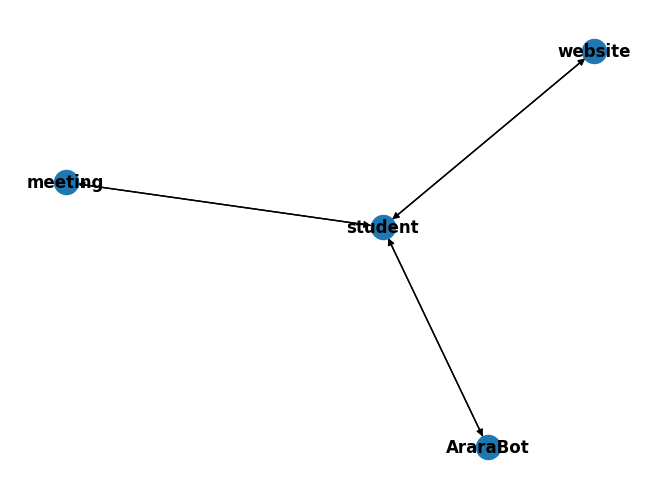

In [5]:
from agents.helpers.graph_utils import visualize_speaker_transitions_dict
visualize_speaker_transitions_dict(speaker_transitions, [user, conversational, meeting_agent, website])

In [6]:
chat_result

ChatResult(chat_id=None, chat_history=[{'content': 'Oi tudo bem?', 'role': 'assistant', 'name': 'student'}, {'content': 'Tudo bem, sim. É um prazer conversar com você. Como posso ajudar ou o que você gostaria de conversar hoje?', 'name': 'AraraBot', 'role': 'user'}, {'content': 'Quem sao os pesquisadores do hiaac?', 'role': 'assistant', 'name': 'student'}, {'content': ' - UNICAMP\nAqui estão alguns dos pesquisadores do H.IAAC:\n\n1. Leandro Villas - Coordenador do grupo de Aprendizado Distribuído\n2. Allan M. de Souza - Pesquisador Associado do grupo de Aprendizado Distribuído\n3. Luiz Bittencourt - Pesquisador Associado do grupo de Aprendizado Distribuído\n4. Eduardo Cerqueira - Pesquisador Colaborador do grupo de Aprendizado Distribuído\n5. Antonio A. F. Loureiro - Pesquisador Colaborador do grupo de Aprendizado Distribuído\n6. Joahannes B. D. da Costa - Pesquisador Colaborador do grupo de Aprendizado Distribuído\n7. Daniel L. Guidoni - Pesquisador Colaborador do grupo de Aprendizado